In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
california=fetch_california_housing()

df=pd.DataFrame(california.data,columns=california.feature_names)
df["Target"]=california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


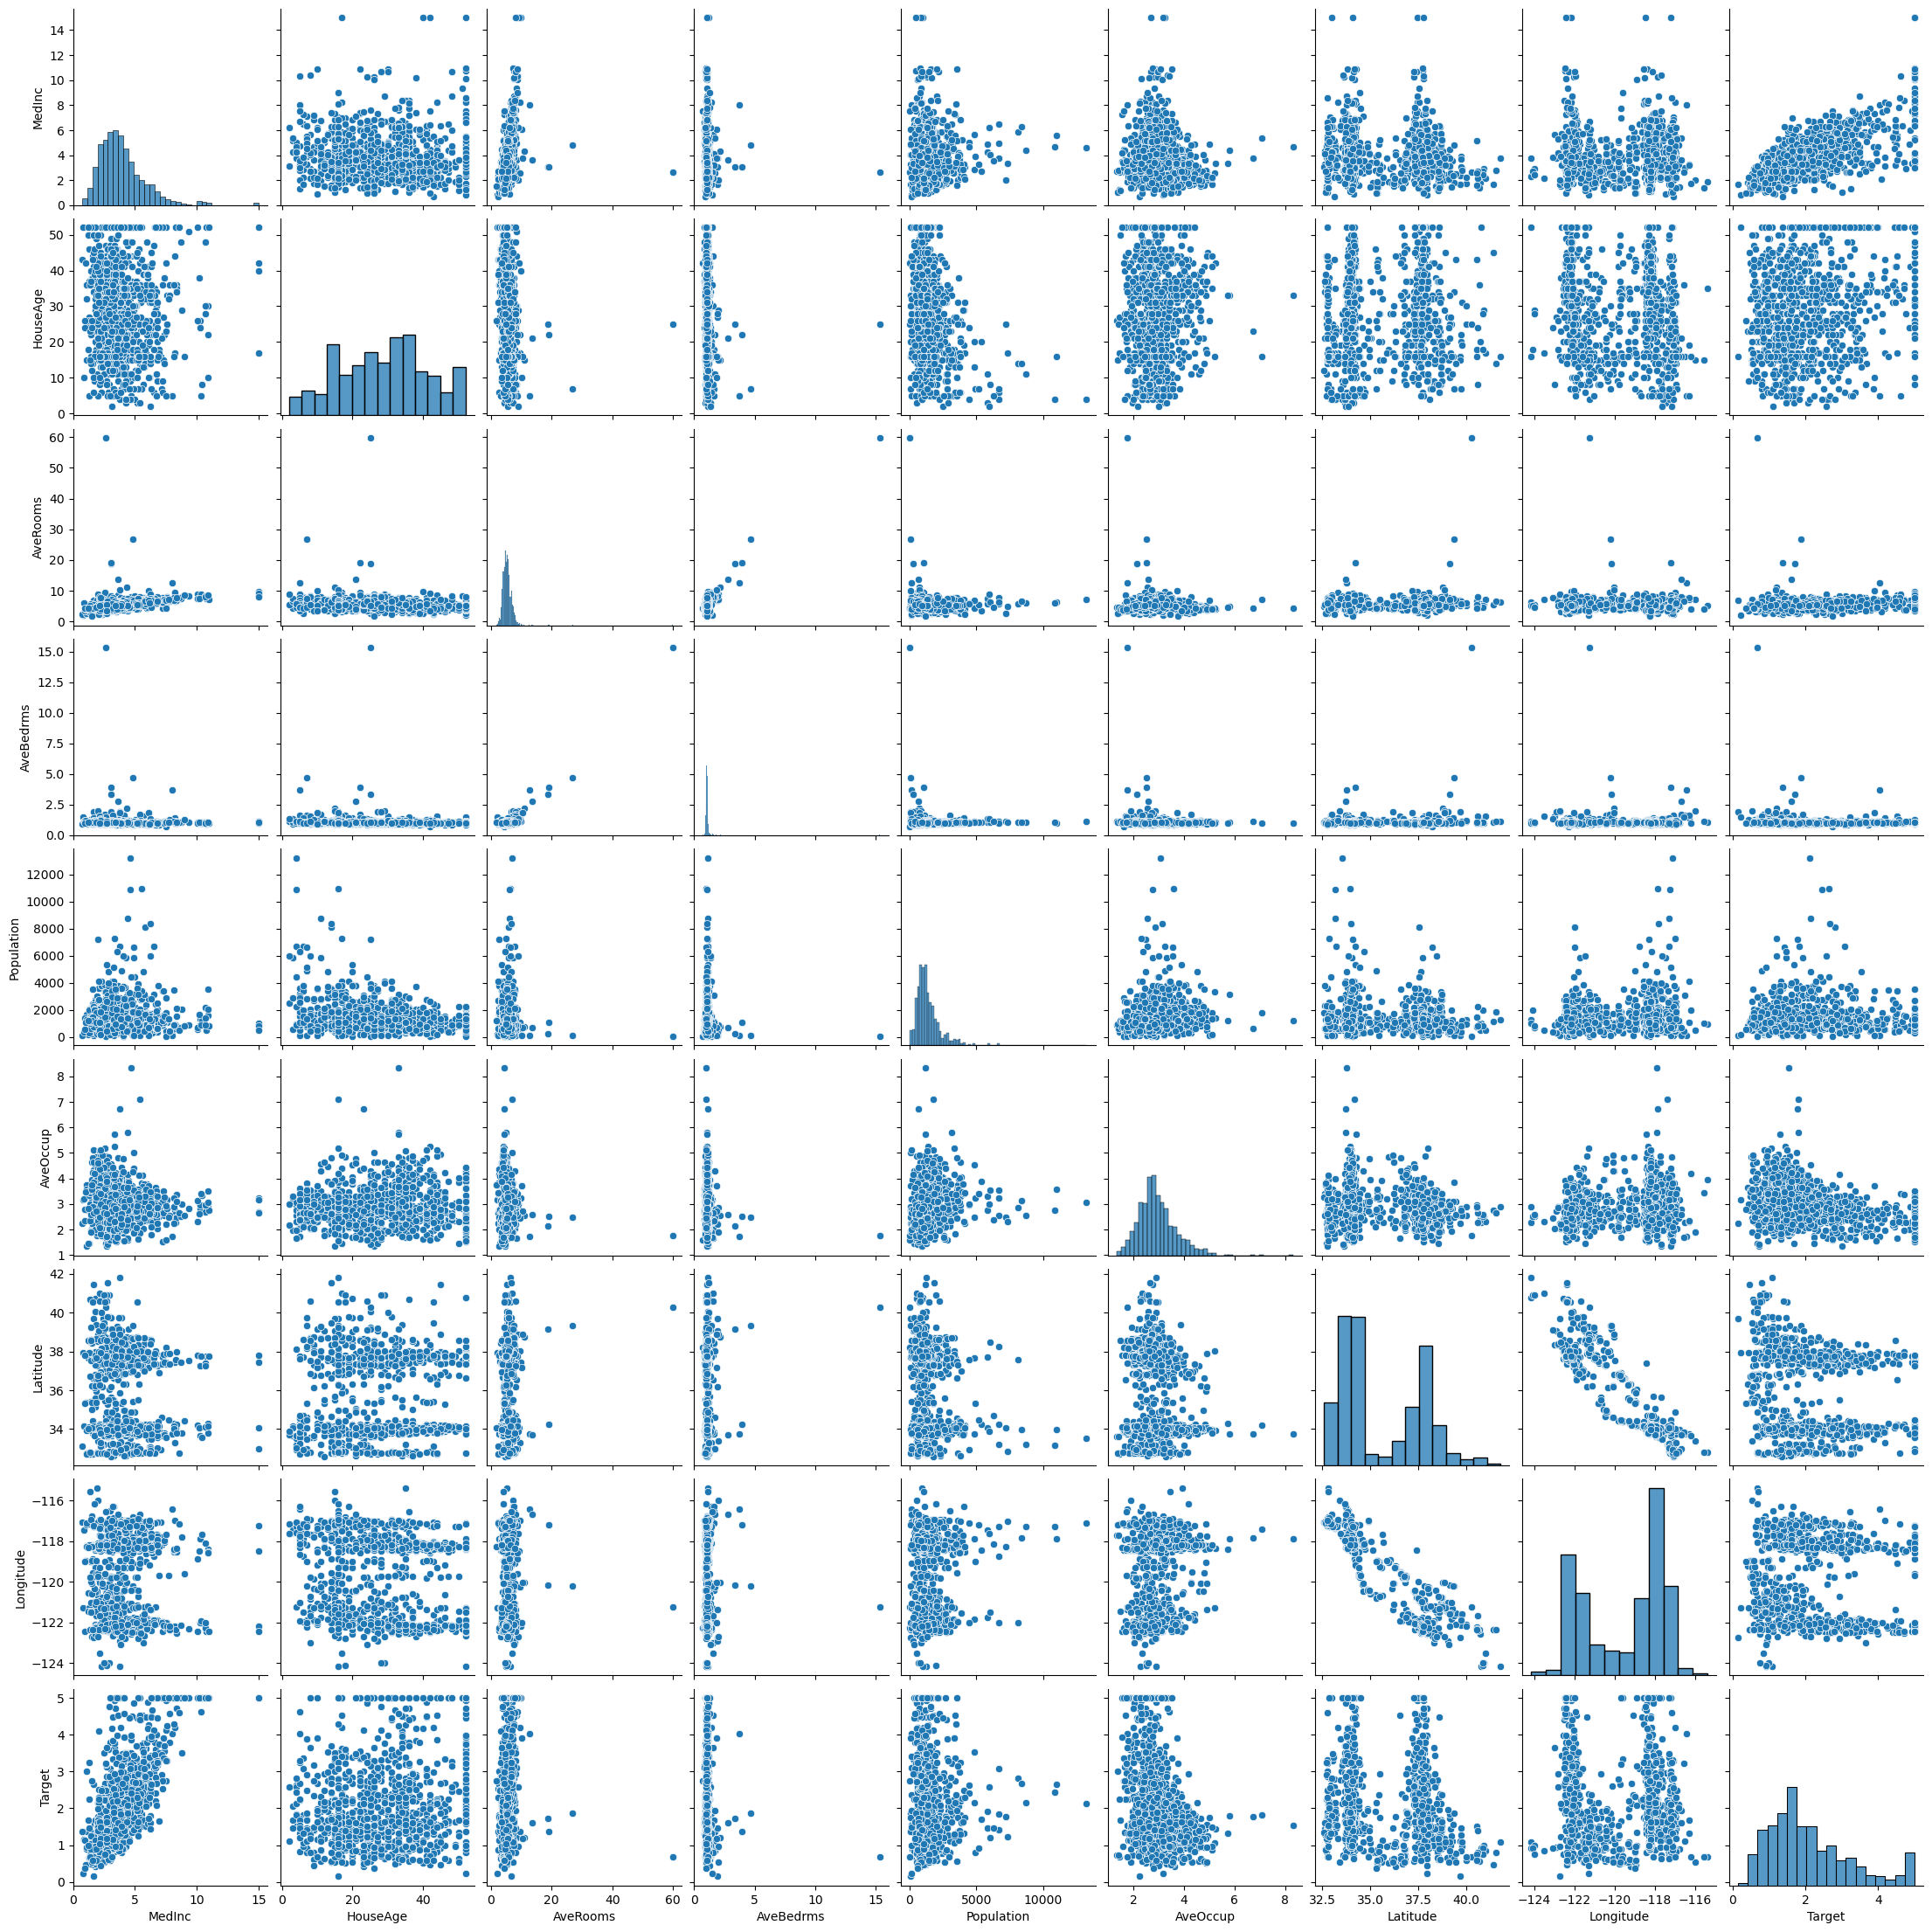

In [3]:
sns.pairplot(df.sample(1000))
plt.show()

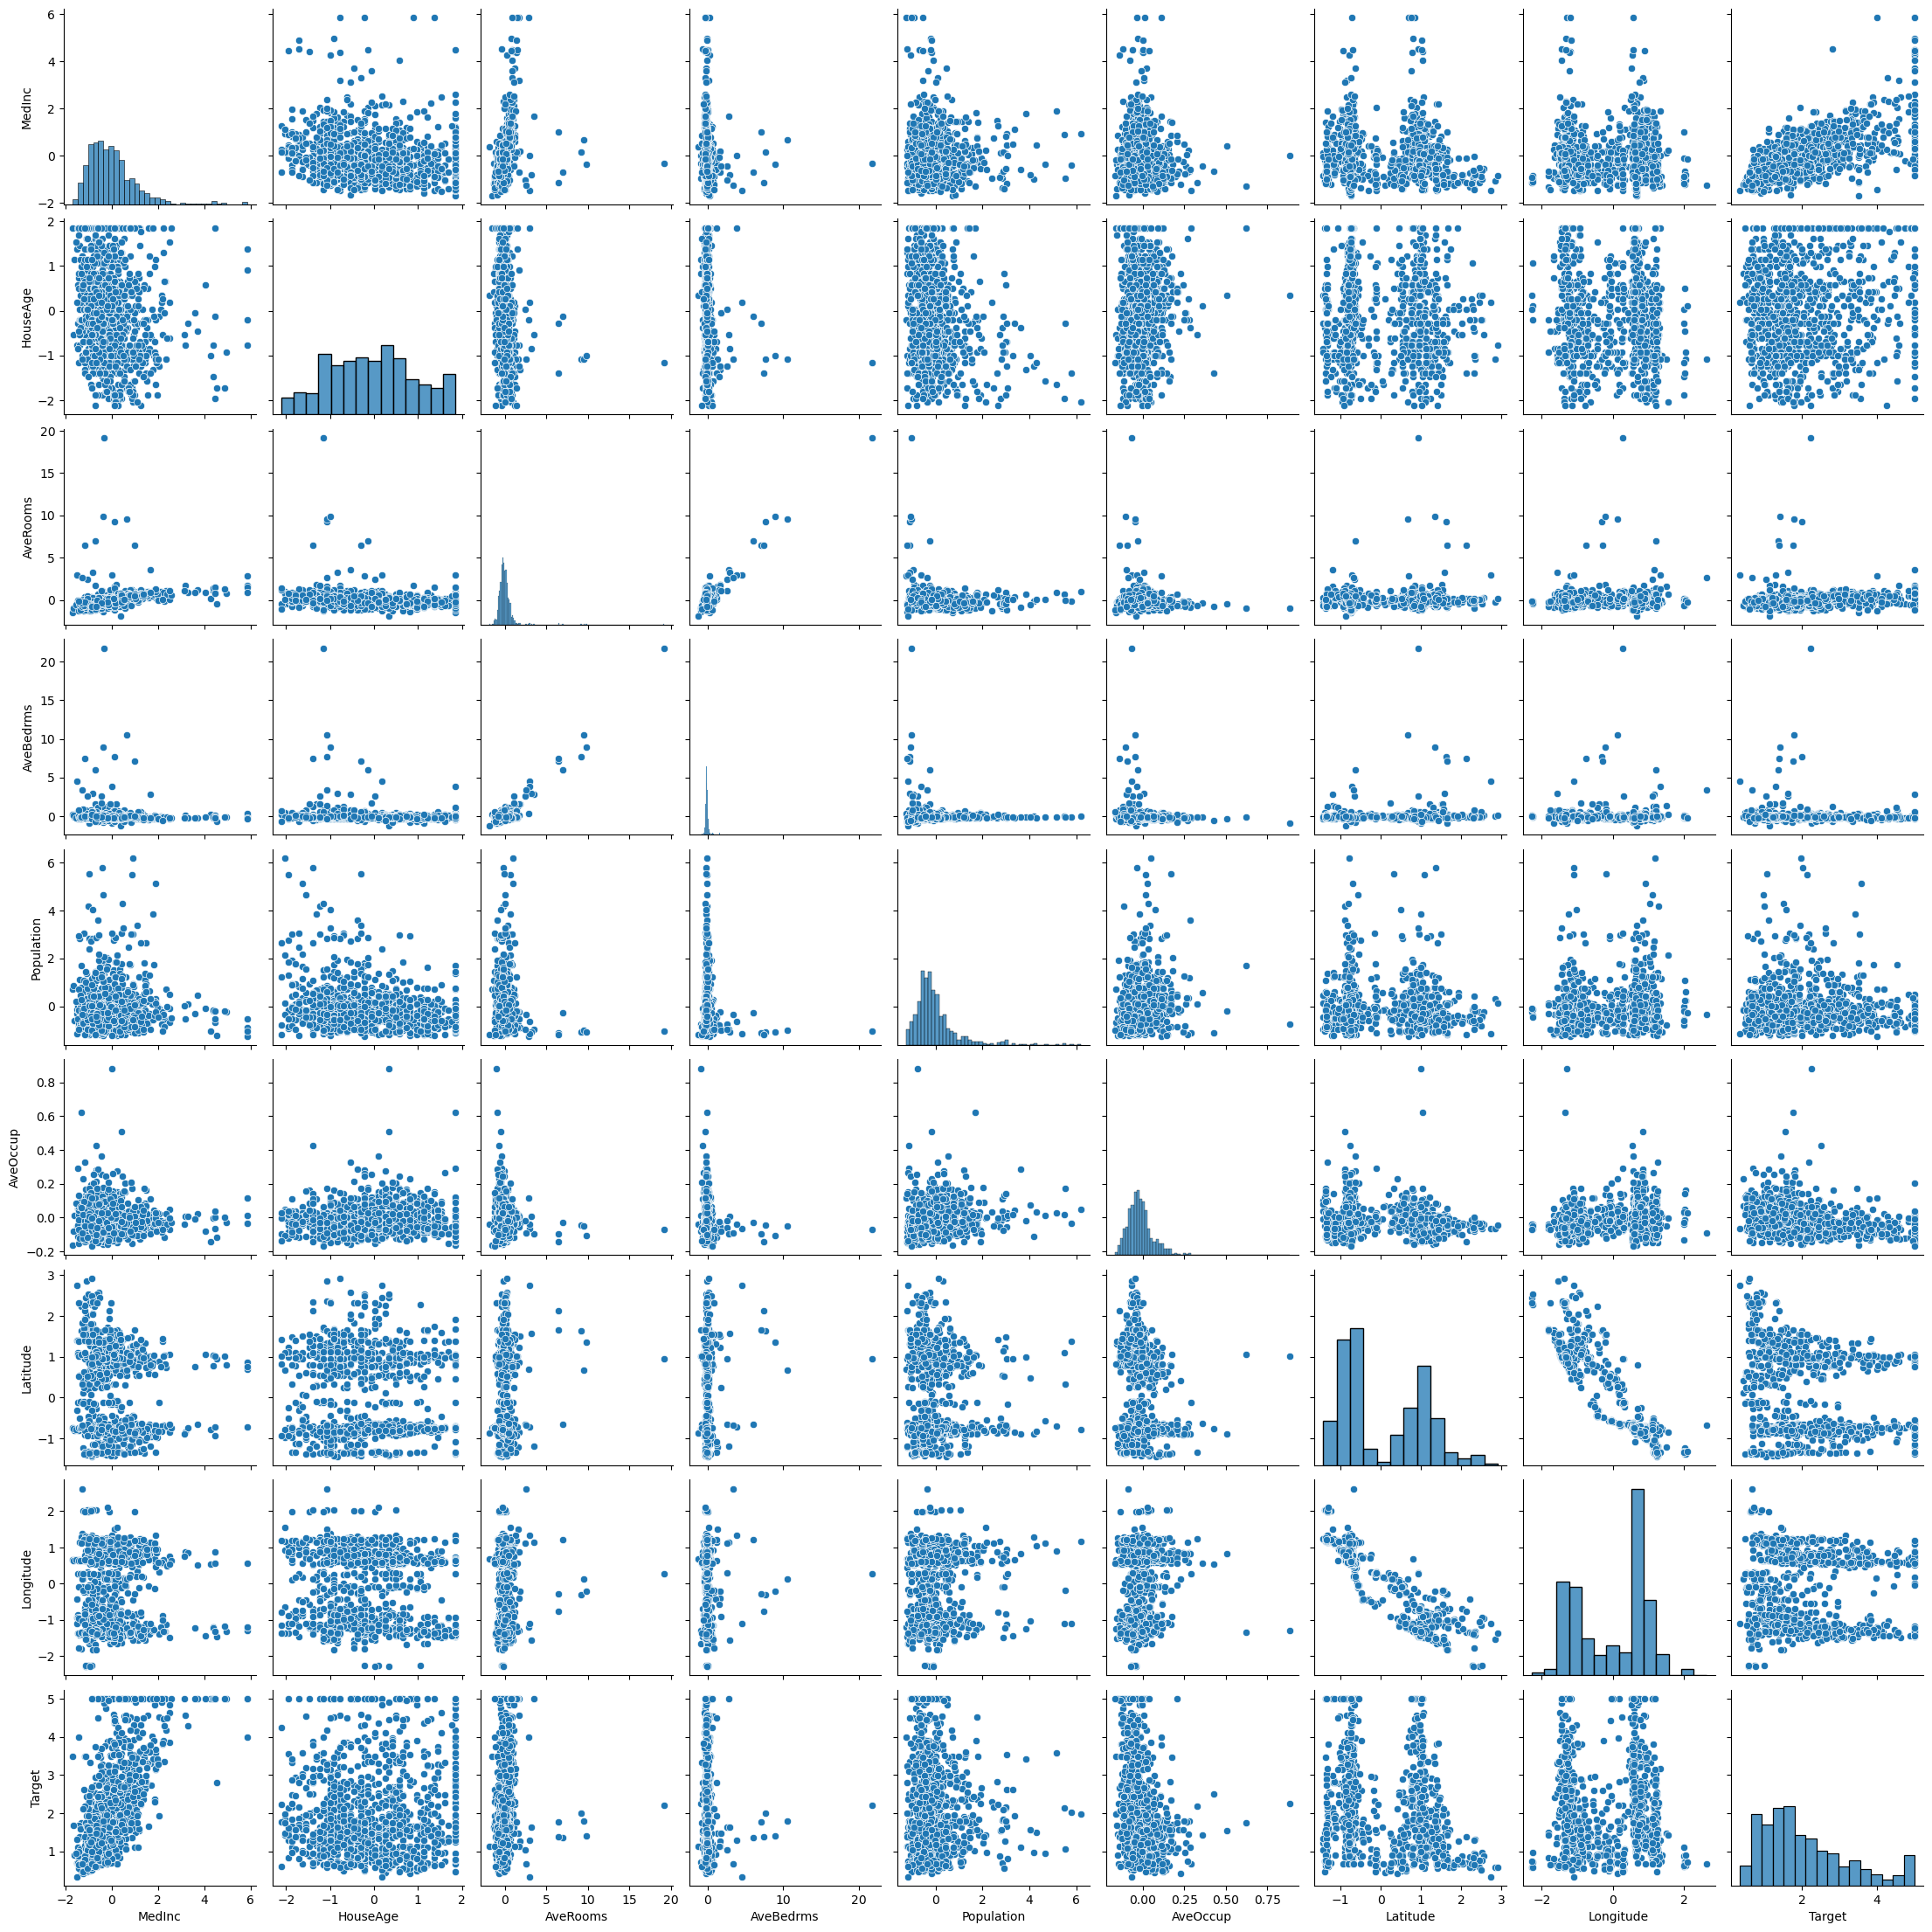

In [6]:
scaler=StandardScaler()
scaler.fit(df.values[:,:-1])
df.values[:,:-1]=scaler.transform(df.values[:,:-1])

sns.pairplot(df.sample(1000))
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
data=torch.from_numpy(df.values).float()
print(data.shape)

torch.Size([20640, 9])


In [9]:
x=data[:,:-1]
y=data[:,-1:]
print(x.shape,y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [10]:
n_epochs=4000
batch_size=256
print_interval=200
learning_rate=1e-2

In [11]:
model=nn.Sequential(
    nn.Linear(x.size(-1),6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3,y.size(-1)),
)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [13]:
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

In [16]:
# SGD Optimizer
# |x| = (total.size, input_dim)
# |y| = (total.size, output_dim)

for i in range(n_epochs):
    # Shuffle the index to feed-forward.
    indices=torch.randperm(x.size(0))

    x_=torch.index_select(x,dim=0,index=indices)
    y_=torch.index_select(y,dim=0,index=indices)

    x_=x_.split(batch_size,dim=0)
    y_=y_.split(batch_size,dim=0)

    y_hat=[]
    total_loss=0

    for x_i,y_i in zip(x_,y_):
        y_hat_i=model(x_i)
        loss=F.mse_loss(y_hat_i,y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        total_loss+=float(loss)
        y_hat+=[y_hat_i]

    total_loss=total_loss/len(x_)
    if(i+1)%print_interval==0:
        print('Epoch %d/%d: loss=%.4f' %(i+1,n_epochs,total_loss))

y_hat=torch.cat(y_hat,dim=0)
y=torch.cat(y_,dim=0)

Epoch 200/4000: loss=0.3262
Epoch 400/4000: loss=0.3142
Epoch 600/4000: loss=0.3099
Epoch 800/4000: loss=0.3090
Epoch 1000/4000: loss=0.3079
Epoch 1200/4000: loss=0.3066
Epoch 1400/4000: loss=0.3049
Epoch 1600/4000: loss=0.3044
Epoch 1800/4000: loss=0.3030
Epoch 2000/4000: loss=0.3015
Epoch 2200/4000: loss=0.3012
Epoch 2400/4000: loss=0.2996
Epoch 2600/4000: loss=0.2991
Epoch 2800/4000: loss=0.2980
Epoch 3000/4000: loss=0.2962
Epoch 3200/4000: loss=0.2953
Epoch 3400/4000: loss=0.2943
Epoch 3600/4000: loss=0.2946
Epoch 3800/4000: loss=0.2943
Epoch 4000/4000: loss=0.2952


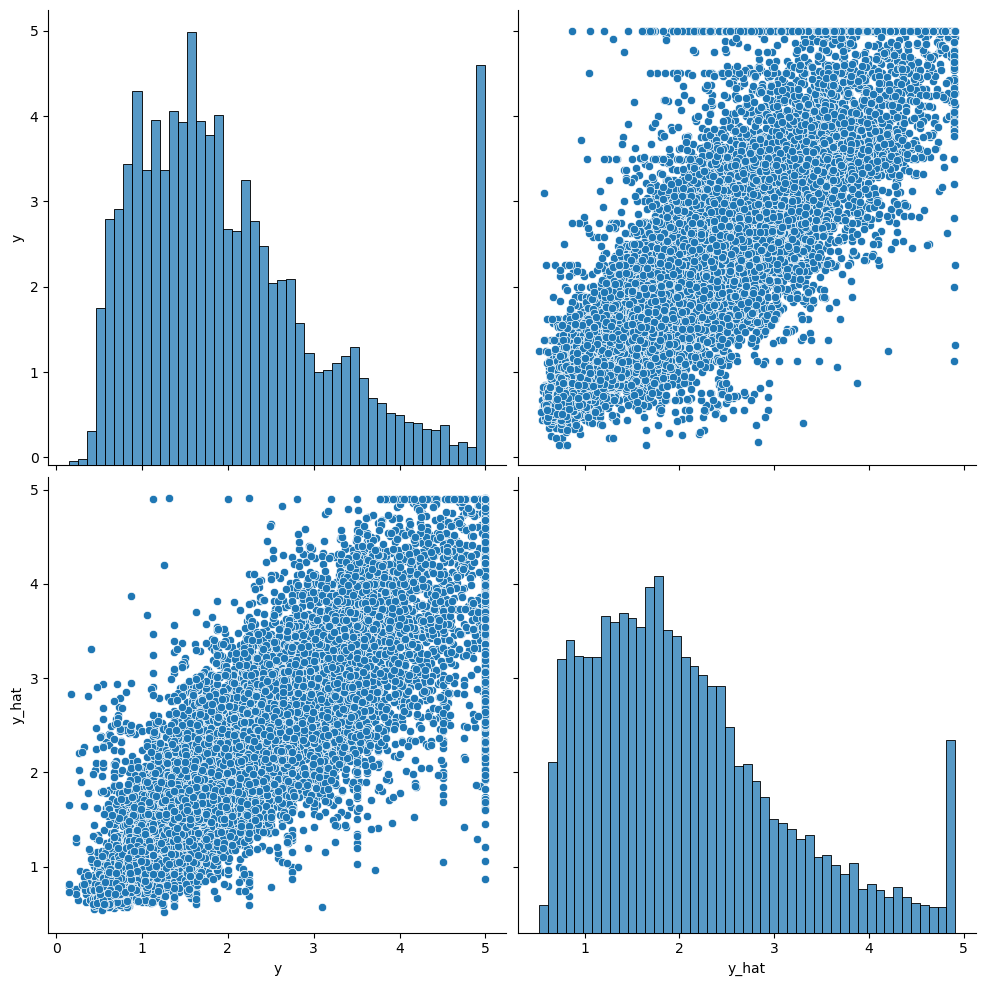

In [18]:
df=pd.DataFrame(torch.cat([y,y_hat],dim=1).detach().numpy(),columns=["y","y_hat"])
sns.pairplot(df,height=5)
plt.show()